In [1]:
import os
import difflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches as mpatches

import sys
sys.path.append('../../')
from rllte.evaluation.visualization import _annotate_and_decorate_axis, plot_interval_estimates, plot_probability_improvement
from rllte.evaluation import Performance, Comparison
from utils import *

ICM (5, 10)
Disagreement (5, 10)
E3B (5, 10)
RND (5, 10)
PseudoCounts (5, 10)
RIDE (5, 10)
RE3 (5, 10)
NGU (5, 10)


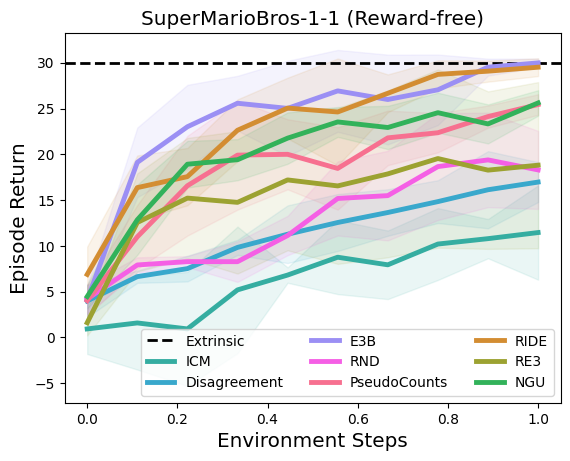

In [49]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU']
colors = sns.husl_palette(len(algos), 0.5)
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(algos)]
fake_patches.append(mpatches.Patch(color='k', label="Extrinsic"))

root = f"/Users/yuanmingqi/Downloads/nips2024_data/best/"
num_points = 10
all_data = {algo: [] for algo in algos}

# plt.figure(figsize=(5.5, 6))
for algo in algos:
    for dir in os.listdir(root):
        if algo.lower() in dir:
            file = f"{root}/{dir}/"
            file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
            data = pd.read_csv(file)['episode_reward']
            data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
            # data = smooth(data, 0.95)
            all_data[algo].append(data)

    all_data[algo] = np.array(all_data[algo])
    print(algo, all_data[algo].shape)

x = np.linspace(0, 1.0, num_points)
plt.axhline(y=30.0, color='k', linestyle='--', linewidth=2, label="Extrinsic")
for algo_idx, algo in enumerate(algos):
    mean, std = np.mean(all_data[algo], axis=0), np.std(all_data[algo], axis=0)
    # mean = np.convolve(mean.flatten(), np.ones(1000)/1000, mode='valid')
    # std = np.convolve(std.flatten(), np.ones(1000)/1000, mode='valid')
    # x = np.linspace(0, 1.0, mean.shape[0])
    plt.plot(x, mean, linewidth=3.5, c=colors[algo_idx], label=algos[algo_idx])
    plt.fill_between(x, mean - std, mean + std, color=colors[algo_idx], alpha=0.10)

plt.xlabel("Environment Steps", fontsize='x-large')
plt.ylabel("Episode Return", fontsize='x-large')
plt.title('SuperMarioBros-1-1 (Reward-free)', fontsize='x-large')
# plt.legend(handles=fake_patches, loc='upper left', fontsize=12)
plt.legend(loc='lower right', fontsize=10, ncols=3)
plt.savefig('figure_best_curves.pdf', bbox_inches='tight', dpi=300)

In [8]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU']
colors = sns.husl_palette(len(algos), 0.5)
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(algos)]
fake_patches.append(mpatches.Patch(color='k', label="Extrinsic"))

candidates = ['baselines', 'best']
pdf = {'candidate': [], 'algo': [], 'reward': []}

all_all_data = {candidate: None for candidate in candidates}
for candidate in candidates:
    prefix = 'best' if candidate == 'best' else 'baselines_new'
    root = f"/Users/yuanmingqi/Downloads/nips2024_data/{prefix}/"
    num_points = 10
    all_data = {algo: [] for algo in algos}

    # plt.figure(figsize=(5.5, 6))
    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir:
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)['episode_reward']
                # use the average of the last 50 episodes
                all_data[algo].append(np.clip(data[-50:].mean(), 0, 50))

                pdf['candidate'].append(candidate)
                pdf['algo'].append(algo)
                pdf['reward'].append(np.clip(data[-50:].mean(), 0, 50))

        all_data[algo] = np.array(all_data[algo])[:, np.newaxis] / 30.0
        # print(algo, all_data[algo].shape)
    
    all_all_data[candidate] = all_data

score_x = np.array([all_all_data['best'][algo] for algo in algos]).T[0]
score_y = np.array([all_all_data['baselines'][algo] for algo in algos]).T[0]
comp = Comparison(scores_x=score_x, scores_y=score_y, get_ci=True)
p_xy = comp.compute_poi()

agg_mean_x = Performance(scores=score_x, get_ci=True).aggregate_mean()
agg_iqm_x = Performance(scores=score_x, get_ci=True).aggregate_median()
agg_mean_y = Performance(scores=score_y, get_ci=True).aggregate_mean()
agg_iqm_y = Performance(scores=score_y, get_ci=True).aggregate_median()
agg_median_x = Performance(scores=score_x, get_ci=True).aggregate_median()
agg_median_y = Performance(scores=score_y, get_ci=True).aggregate_median()
agg_og_x = Performance(scores=score_x, get_ci=True).aggregate_og()
agg_og_y = Performance(scores=score_y, get_ci=True).aggregate_og()

In [3]:
p_xy

(0.8175,
 array([[0.7175],
        [0.9025]]))

In [6]:
# compute the performan gain 
(agg_iqm_x[0] - agg_iqm_y[0]) / agg_iqm_y[0]

0.8613215698253146

In [7]:
(agg_mean_x[0] - agg_mean_y[0]) / agg_mean_y[0]

0.6606560747951475

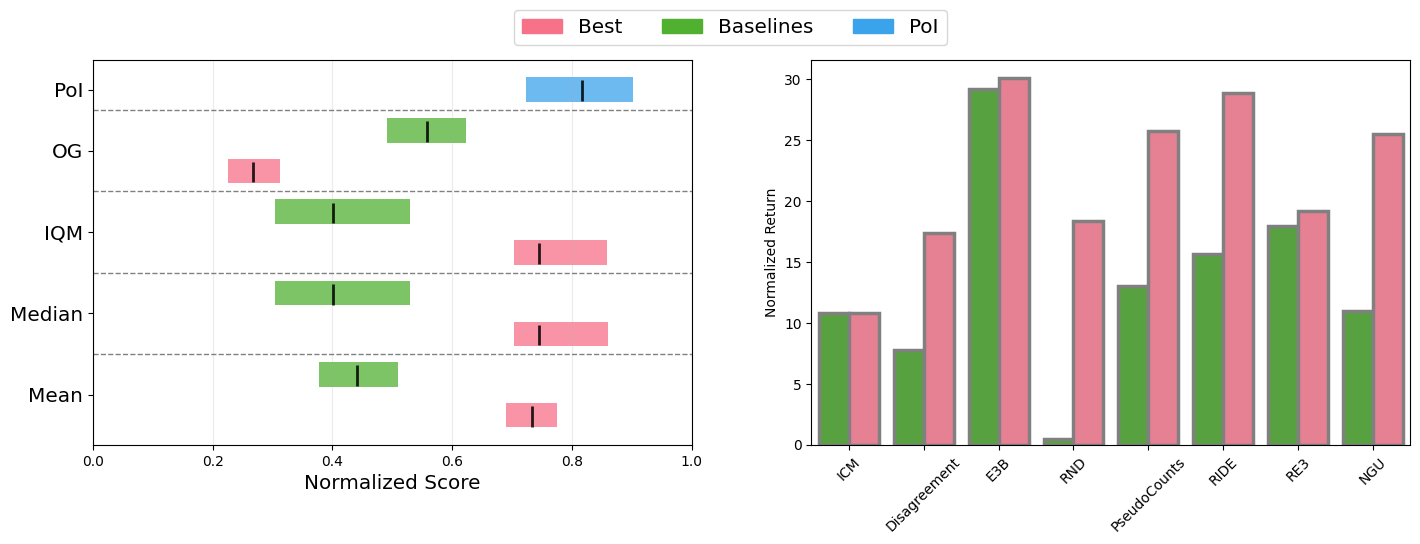

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
ax = axes[0]
palette = sns.husl_palette(3)
legends = ['Best', 'Baselines', 'PoI']
fake_patches = [mpatches.Patch(color=palette[i], label=legends[i]) for i in range(3)]

colors = [palette[0], palette[1], palette[0], palette[1], palette[0], palette[1], palette[0], palette[1], palette[2]]
labels = ['Mean', 'Mean', 'Median', 'Median', 'IQM', 'IQM', 'OG', 'OG', 'PoI']
for idx, metric in enumerate([agg_mean_x, agg_mean_y, agg_iqm_x, agg_iqm_y, 
                              agg_median_x, agg_median_y, agg_og_x, agg_og_y, p_xy]):
    lower, upper = metric[1][0], metric[1][1]
    ax.barh(
        y=idx, width=upper - lower, height=0.6, left=lower, alpha=0.75, label=labels[idx], color=colors[idx]
    )

    ax.vlines(
        x=metric[0],
        ymin=idx - (7.5 * 0.6 / 16),
        ymax=idx + (6 * 0.6 / 16),
        label='CI',
        color="k",
        alpha=0.85,
        linewidth=2
    )
ax.grid(True, axis="x", alpha=0.25)
ax.axhline(1.5, color='gray', linestyle='--', linewidth=1)
ax.axhline(3.5, color='gray', linestyle='--', linewidth=1)
ax.axhline(5.5, color='gray', linestyle='--', linewidth=1)
ax.axhline(7.5, color='gray', linestyle='--', linewidth=1)
ax.set_yticks([0.5, 2.5, 4.5, 6.5, 8], ['Mean', 'Median', 'IQM', 'OG', 'PoI'], fontsize='x-large')
ax.set_xlim(0, 1)
ax.set_xlabel('Normalized Score', fontsize='x-large')

sns.barplot(data=pd.DataFrame(pdf), x='algo', y='reward', 
            hue='candidate', ax=axes[1], palette=[colors[1], colors[0]],
            errorbar=None, capsize=.2,
            linewidth=2.5, edgecolor=".5")

# ax.set_xticks(x)
# ax.set_xticklabels(algos)
axes[1].set_xlabel('')
axes[1].set_ylabel('Normalized Return')
axes[1].tick_params(axis='x', rotation=45)
axes[1].get_legend().remove()

fig.legend(fake_patches, legends, loc='upper center', 
    fancybox=True, ncol=3, 
    fontsize='x-large',
    bbox_to_anchor=(0.5, 1.0))
fig.savefig('figure_best_comparison.pdf', bbox_inches='tight', dpi=300)